In [1]:
def plot_top_conversion_rates(df, category_col, target_col, top_n=10):
    
    # 각 범주별로 target_col의 True와 False의 개수를 집계
    conversion_counts = df.groupby([category_col, target_col]).size().unstack(fill_value=0)

    # True 비율
    conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)

    # True 비율이 높은 상위 N개 범주를 선택
    top_categories = conversion_rates[True].sort_values(ascending=False).head(top_n).index

    top_conversion_rates = conversion_rates.loc[top_categories]

    ax = top_conversion_rates.plot(kind='bar', stacked=True, figsize=(10, 5))

    plt.title(f'Top {top_n}')
    plt.xlabel(category_col)
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45)
    plt.legend(title=target_col, labels=['False', 'True'])

    # 그래프 표시
    plt.tight_layout()
    plt.show()


# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier



from category_encoders import TargetEncoder


import seaborn as sns
import matplotlib.pyplot as plt

### 데이터 셋 읽어오기

In [3]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [4]:
df_train

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.00,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.00,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.00,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.00,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.00,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,/Sląskie/Poland,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,...,LGEPL,3 months ~ 6 months,0,0,0.000026,0.028777,public facility,Others,694,False
59295,0.75,/Bogotá DC /Colombia,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGECB,9 months ~ 1 year,0,0,0.000026,0.028777,public facility,NaN,39,False
59296,0.75,/Pisco/Peru,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEPR,less than 3 months,0,0,0.000026,0.028777,public facility,NaN,125,False
59297,1.00,/santa cruz bolivia/Peru,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,...,LGEPR,more than a year,0,0,0.000026,0.028777,public facility,NaN,134,False


## EDA

| Field                   | 설명                                                         |
| :---------------------- | :----------------------------------------------------------- |
| bant_submit             | MQL 구성 요소들 중 [1]Budget(예산), [2]Title(고객의 직책/직급), [3]Needs(요구사항), [4]Timeline(희망 납기일) 4가지 항목에 대해서 작성된 값의 비율 |
| customer_country        | 고객의 국적                                                  |
| business_unit           | MQL 요청 상품에 대응되는 사업부                              |
| com_reg_ver_win_rate    | Vertical Level 1, business unit, region을 기준으로 oppty 비율을 계산 |
| customer_idx            | 고객의 회사명                                                |
| customer_type           | 고객 유형                                                    |
| enterprise              | Global 기업인지, Small/Medium 규모의 기업인지                |
| historical_existing_cnt | 이전에 Converted(영업 전환) 되었던 횟수                      |
| id_strategic_ver        | (도메인 지식) 특정 사업부(Business Unit이 ID일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여 |
| it_strategic_ver        | (도메인 지식) 특정 사업부(Business Unit이 IT일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여 |
| idit_strategic_ver      | Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현 |
| customer_job            | 고객의 직업군                                                |
| lead_desc_length        | 고객이 작성한 Lead Descriptoin 텍스트 총 길이                |
| inquiry_type            | 고객의 문의 유형                                             |
| product_category        | 요청 제품 카테고리                                           |
| product_subcategory     | 요청 제품 하위 카테고리                                      |
| product_modelname       | 요청 제품 모델명                                             |
| customer_country.1      | 담당 자사 법인명 기반의 지역 정보(대륙)                      |
| customer_position       | 고객의 회사 직책                                             |
| response_corporate      | 담당 자사 법인명                                             |
| expected_timeline       | 고객의 요청한 처리 일정                                      |
| ver_cus                 | 특정 Vertical Level 1(사업영역) 이면서 Customer_type(고객 유형)이 소비자(End-user)인 경우에 대한 가중치 |
| ver_pro                 | 특정 Vertical Level 1(사업영역) 이면서 특정 Product Category(제품 유형)인 경우에 대한 가중치 |
| ver_win_rate_x          | 전체 Lead 중에서 Vertical을 기준으로 Vertical 수 비율과 Vertical 별 Lead 수 대비 영업 전환 성공 비율 값을 곱한 값 |
| ver_win_ratio_per_bu    | 특정 Vertical Level1의 Business Unit 별 샘플 수 대비 영업 전환된 샘플 수의 비율을 계산 |
| business_area           | 고객의 사업 영역                                             |
| business_subarea        | 고객의 세부 사업 영역                                        |
| lead_owner              | 영업 담당자 이름                                             |
| is_converted            | 영업 성공 여부. True일 시 성공.                              |

In [5]:
print(df_train['bant_submit'].value_counts())
print(df_test['bant_submit'].value_counts())

bant_submit
0.50    17192
1.00    17061
0.25    12852
0.75    11681
0.00      513
Name: count, dtype: int64
bant_submit
1.00    2070
0.25    1522
0.50     667
0.75     545
0.00     467
Name: count, dtype: int64


In [6]:
print(df_train['bant_submit'].isnull().sum())
print(df_test['bant_submit'].isnull().sum())

0
0


고유값 : 0.00, 0.25, 0.50, 0.75, 1.00
결측치 : x

# 1. customer_country

In [7]:
df_train['customer_country'].isnull().sum()

982

In [8]:
df_train['customer_country.1'].isnull().sum()

982

In [9]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

similarity_score = similar(df_train['customer_country.1'].astype(str), df_train['customer_country'].astype(str))
print(f'유사도 확인 : {similarity_score:.2%}')


유사도 확인 : 100.00%


In [10]:
# customer_country.1과 유사도 판단 결과 100% 확인. 즉 customer_country.1 drop해야함.

In [11]:
df_train.drop('customer_country.1', axis=1, inplace=True)
df_test.drop('customer_country.1', axis=1, inplace=True)

In [12]:
import pandas as pd


def clean_customer_country(df):
    df_c = df['customer_country'].fillna('None')
    df_c = df_c.str.replace(pat='[ ]', repl='', regex=True).reset_index().drop('index', axis=1)

    
    c_list = df_c['customer_country'].str.split('/')
    result = [c[-1] for c in c_list]
    
  
    result_df = pd.DataFrame(result, columns=['customer_country'])

   
    replace_country = {
       'Manaus': 'Brazil',
    'Aparecida' : 'Brazil',
    'BR' : 'Brazil',
    'Dourados' : 'Brazil',
    'Cuiabá' : 'Brazil',
    'Recife' : 'Brazil',
    'SãoPaulo' : 'Brazil',
    'SaoPaulo' : 'Brazil',
    'JoãoPessoa' : 'Brazil',
    'Capãodacanoa' : 'Brazil',
    'BeloHorizonte' : 'Brazil',
    'SãoPaulo,Pinheiros' : 'Brazil',
    'CentrodeProduçãoAudiovisual-SescSãoPaulo' : 'Brazil',
    'FozdeIguaçu-PRAvenidaTancredoNeves6731JardimItaipu' : 'Brazil',
    'ViaE.DeAmicis,23.90044Carini(PA)' : 'Italy',
    'NewHampshire': 'UnitedStates',
    '1HoagDr.' : 'UnitedStates',
    '21903RanierLn' : 'UnitedStates',
    'JacksonvilleFlorida' : 'UnitedStates',
    'USVirginIslands' : 'UnitedStates',
    '3NassonAvenue' : 'UnitedStates',
    'Zip98433' : 'UnitedStates',
    'Nevada' : 'UnitedStates',
    'Ohio' : 'UnitedStates',
    'AnandViharDelhi' : 'India',
    'uttarpradesh' : 'India',
    'mumbai' : 'India',
    'Telangana' : 'India',
    'bangalore': 'India',
    'gujarat' : 'India',
    'gurgaon': 'India',
    'indore' : 'India',
    'kerela' : 'India',
    'Chennai' : 'India',
    'lucknow' : 'India',
    'Gujarat' : 'India',
    'Pune' : 'India',
    'odisha' : 'India',
    'hyderabad' : 'India',
    'bhilwara' : 'India',
    'CACERES' : 'Spain',
    'GRANCANARIASPLAYADELINGLES' : 'Spain',
    'VALENCIA' : 'Spain',
    'MADRID' : 'Spain',
    'SPAIN' : 'Spain',
    '1605Ave.PoncedeLeón,Suite400SanJuan,00909,PuertoRico' :'PuertoRico',
    'ΘέσηΠέτσαΒακαλοπούλουΒΙΟΠΑΠαλλήνης15351' : 'Greece',
    'Barranquilla' : 'Colombia',
    'Bucaramanga' : 'Colombia',
    'Cartagena' : 'Colombia',
    'COLOMBIA' : 'Colombia',
    'CARRERA11A94-46EDIFICIOCHICO3000PISO3BOGOTA' : 'Colombia',
    '1919MinnesotaCt,Mississauga,ONL5N' : 'Canada',
    'HaNoi' : 'Vietnam',
    'ARGENTINA' : 'Argentina',
    'EGYPT' : 'Egypt',
    'PerU' : 'Peru',
    'UAEDubai' : 'U.A.E',
    'Antigua' : 'AntiguaandBarbuda',
    'Dominicanrepublic' : 'DominicanRepublic',
    'NetherlandsAntilles' : 'Netherlands', 
    'A' : 'None',
    'country' : 'None',
    '':'None'
    }

    result_df['customer_country'] = result_df['customer_country'].replace(replace_country)

    result_df.loc[result_df['customer_country'].str.contains('UnitedStates'), 'customer_country'] = 'UnitedStates'
    result_df.loc[result_df['customer_country'].str.contains('Italy'), 'customer_country'] ='Italy'
    result_df.loc[result_df['customer_country'].str.contains('Colombia'), 'customer_country'] ='Colombia'
    result_df.loc[result_df['customer_country'].str.contains('ALICANTE'), 'customer_country'] ='Spain'

    result_df.loc[result_df['customer_country'].str.contains(r'^[A-Z]{2}$|[A-Z]{2}\d{5}$'), 'customer_country'] = 'UnitedStates'
    result_df.loc[result_df['customer_country'].str.contains(r'\b[A-Z]{2}\d{5}\b|USA'), 'customer_country'] = 'UnitedStates'
    result_df['customer_country'][(result_df['customer_country'].str.contains(r'\d{5}'))
                             & (~result_df['customer_country'].str.contains('@'))] = 'UnitedStates'
    result_df.loc[result_df['customer_country'].str.contains(r'\d{4}$|^\d{4}|^\d{3}'), 'customer_country'] = 'UnitedStates'

    result_df['customer_country'][result_df['customer_country'].str.contains('@')] = 'None'
    return result_df


df_train['customer_country'] = clean_customer_country(df_train)
df_test['customer_country'] = clean_customer_country(df_test)


In [13]:
df_train['customer_country'].unique()

array(['Philippines', 'India', 'Nigeria', 'SaudiArabia', 'Singapore',
       'Brazil', 'U.A.E', 'SouthAfrica', 'UnitedStates', 'Colombia',
       'Mexico', 'Ghana', 'Egypt', 'DemocraticRepublicoftheCongo',
       'Ethiopia', 'Australia', 'None', 'Kenya', 'Indonesia', 'Oman',
       'Pakistan', 'UnitedKingdom', 'Guatemala', 'Panama', 'Canada',
       'Bangladesh', 'PapuaNewGuinea', 'UnitedRepublicofTanzania',
       'Qatar', 'Afghanistan', 'Chile', 'Mozambique', 'Turkey', 'Türkiye',
       'ElSalvador', 'Togo', 'Jordan', 'Iraq', 'Israel', 'SriLanka',
       'SouthKorea', 'Portugal', 'Mauritania', 'Uruguay', 'Peru',
       'Germany', 'Romania', 'Norway', 'Jamaica', 'Hungary', 'Poland',
       'Czech', 'Spain', 'Argentina', 'Ecuador', 'Senegal', 'HongKong',
       'Malaysia', 'Japan', 'Kuwait', 'Ireland', 'Albania', 'Greece',
       'Algeria', 'Nicaragua', 'Slovenia', 'Italy', 'Netherlands',
       'DominicanRepublic', 'France', 'Uganda', 'Iran', 'Paraguay',
       'Bolivia', 'Namibia', '

In [14]:
value_counts_result = df_test['customer_country'].value_counts()
value_counts_result

customer_country
Brazil          1045
India            906
UnitedStates     780
Philippines      289
None             220
                ... 
Jamaica            1
Somalia            1
Israel             1
Kosovo             1
Pakistan           1
Name: count, Length: 92, dtype: int64

In [15]:
df_test['customer_country'].unique()

array(['Brazil', 'UnitedStates', 'U.A.E', 'Germany', 'Egypt', 'France',
       'None', 'UNITEDSTATES', 'Indonesia', 'India', 'Italy', 'Argentina',
       'Türkiye', 'SaudiArabia', 'Philippines', 'Peru', 'Vietnam',
       'Australia', 'Chile', 'Colombia', 'HongKong', 'Mexico', 'Thailand',
       'Serbia', 'BosniaandHerzegovina', 'Netherlands', 'Hungary',
       'Panama', 'UnitedKingdom', 'SouthAfrica', 'Maldives', 'Singapore',
       'Ecuador', 'Venezuela', 'Israel', 'Austria', 'Guatemala',
       'Belgium', 'Oman', 'Tunisia', 'Nicaragua', 'Somalia', 'China',
       'Canada', 'DemocraticRepublicoftheCongo', 'Poland',
       'DominicanRepublic', 'Spain', 'Greece', 'Qatar',
       'TrinidadandTobago', 'Kosovo', 'Algeria', 'Jordan', 'Bulgaria',
       'Cambodia', 'Romania', 'Georgia', 'ElSalvador', 'Jamaica',
       'Englewood,CO', 'Honduras', 'Switzerland', 'Cyprus', 'Bangladesh',
       'Kuwait', 'TurksandCaicosIslands', 'Portugal', 'Uruguay',
       'CostaRica', 'PuertoRico', 'Nigeria',

In [16]:
# customer_idx 값별 빈도수 계산
country_counts_train = df_train['customer_country'].value_counts()
country_counts_test = df_test['customer_country'].value_counts()

# 빈도수가 1인 값들을 0으로 대체
df_train['customer_country'] = df_train['customer_country'].apply(lambda x: 0 if country_counts_train[x] == 1 else x)
df_test['customer_country'] = df_test['customer_country'].apply(lambda x: 0 if country_counts_test[x] == 1 else x)

In [17]:
train_vals = set(df_train['customer_country'].unique())
test_vals = set(df_test['customer_country'].unique())

test_not_train = test_vals - train_vals

print(test_not_train)


{'StMaarten', 'UNITEDSTATES'}


In [18]:
# 'customer_country' 열에서 df_train에 없는 값을 'Other'로 대체
df_test['customer_country'] = df_test['customer_country'].apply(lambda x: 'Other' if x in test_not_train else x)


In [19]:
df_train['customer_country'].value_counts()

customer_country
India                     16868
Brazil                     8753
UnitedStates               4159
None                       3042
Mexico                     2753
                          ...  
TurksandCaicosIslands         2
Somalia                       2
IvoryCoast                    2
CentralAfricanRepublic        2
Slovakia                      2
Name: count, Length: 164, dtype: int64

In [20]:
unique_values_count = df_train['customer_country'].nunique()
print("고유값 개수:", unique_values_count)


고유값 개수: 164


In [21]:
# 빈도수가 낮은 국가에 대해서 처리 방안. ex) 5회 미만은 other로 분류 한다던가? 해야할듯!

In [22]:
# 특정 빈도수 이하인 국가들을 'other'로 변경
counts = df_train['customer_country'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['customer_country'] = df_train['customer_country'].replace(low_frequency, 'Other')


In [23]:
df_train['customer_country'].value_counts()

customer_country
India                16868
Brazil                8753
UnitedStates          4159
None                  3042
Mexico                2753
                     ...  
Angola                  11
Uganda                  11
Barbados                10
TrinidadandTobago       10
Czech                   10
Name: count, Length: 101, dtype: int64

In [24]:
# 특정 빈도수 이하인 국가들을 'other'로 변경
counts = df_test['customer_country'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['customer_country'] = df_test['customer_country'].replace(low_frequency, 'Other')


In [25]:
df_test['customer_country'].value_counts()

customer_country
Brazil           1045
India             906
UnitedStates      780
Philippines       289
None              220
Peru              211
Mexico            180
Other             137
Colombia          127
U.A.E             120
Italy             120
Chile             108
SaudiArabia       102
Indonesia          95
Egypt              95
Vietnam            69
Germany            67
Australia          66
Argentina          65
Türkiye            51
HongKong           48
UnitedKingdom      44
Poland             42
Singapore          41
Thailand           38
Panama             29
0                  27
Serbia             20
SouthAfrica        19
Greece             19
Canada             17
Oman               16
France             16
Spain              15
Ecuador            14
Hungary            13
Name: count, dtype: int64

In [26]:
unique_values_count = df_train['customer_country'].nunique()
print("고유값 개수:", unique_values_count)


고유값 개수: 101


In [27]:
from category_encoders import TargetEncoder

# 타겟 인코딩
target_encoder = TargetEncoder(smoothing=0.3)  # 스무딩 값을 조절하면서 객체 생성


df_train['customer_country'] = target_encoder.fit_transform(df_train['customer_country'], df_train['is_converted'])
df_test['customer_country'] = target_encoder.transform(df_test['customer_country'])


In [28]:
unique_values_count = df_train['customer_country'].nunique()
print("고유값 개수:", unique_values_count)


고유값 개수: 88


In [29]:
df_train['customer_country'].unique()

array([9.14752822e-02, 7.09627697e-02, 4.66666667e-01, 7.82312925e-02,
       1.15044248e-01, 6.40923112e-02, 1.33091349e-01, 8.95522388e-02,
       2.13993748e-01, 3.46038114e-02, 5.70286960e-02, 3.33333333e-01,
       2.53565769e-02, 1.54340836e-01, 8.17889002e-02, 1.26684636e-01,
       7.33070348e-02, 1.75438596e-02, 1.26865672e-01, 9.78260870e-02,
       3.44827586e-02, 1.57894737e-02, 1.03896104e-01, 9.49554896e-02,
       6.96864111e-02, 1.36986301e-02, 8.17889003e-02, 1.50684932e-01,
       0.00000000e+00, 7.09046455e-02, 8.17888691e-02, 4.18118467e-02,
       2.29885057e-02, 3.33333333e-02, 3.66492147e-02, 8.69565217e-02,
       3.71304176e-06, 4.08944502e-02, 1.68000000e-01, 8.69562871e-02,
       3.87665198e-02, 5.13392857e-02, 2.81250000e-01, 4.87960349e-02,
       9.52380952e-02, 6.95443645e-02, 8.17889003e-02, 2.28873239e-02,
       1.74348697e-01, 2.12014134e-02, 8.17889003e-02, 4.01534527e-01,
       5.45454545e-02, 6.57894737e-02, 8.00000001e-02, 1.59090909e-01,
      

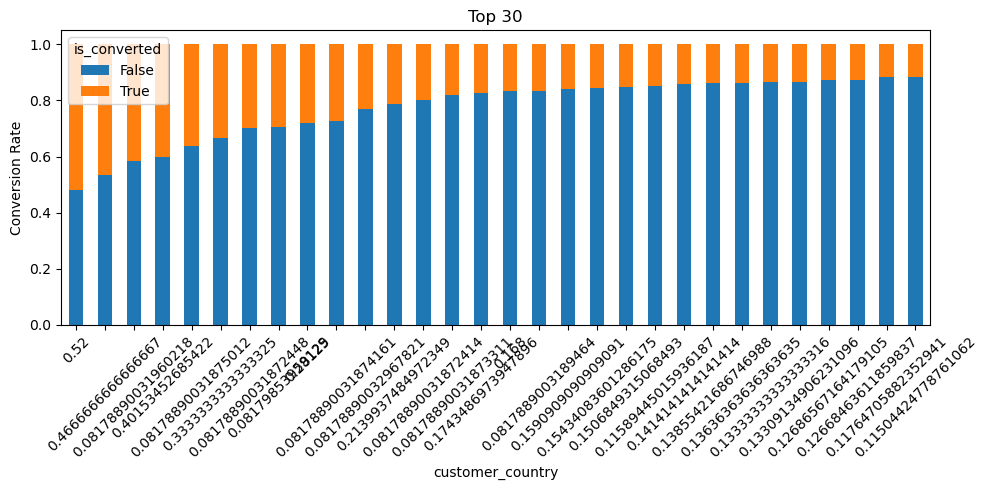

In [30]:
plot_top_conversion_rates(df_train, 'customer_country', 'is_converted', top_n=30)

# 2. business_unit

# 3. com_reg_ver_win_rate
- (Vertical Level 1, business unit, region을 기준으로 oppty 비율을 계산)

In [31]:
print(df_train['com_reg_ver_win_rate'].isnull().sum())
print(df_test['com_reg_ver_win_rate'].isnull().sum())

44731
3483


In [32]:
df_train['com_reg_ver_win_rate'].unique()

array([0.06666667, 0.08888889, 0.04081633, 0.00393701,        nan,
       0.05753425, 0.075     , 0.04464286, 0.08433735, 0.0199005 ,
       0.07494867, 0.04347826, 0.03119584, 0.14705882, 0.03305785,
       0.08069164, 0.33333333, 0.04310345, 0.11627907, 0.01351351,
       0.04854369, 0.01818182, 0.01185771, 0.21428571, 0.3902439 ,
       0.03225806, 0.01754386, 0.03278689, 0.05555556, 0.01515152,
       0.46153846, 0.06818182, 0.08333333, 0.26923077, 0.18181818,
       0.23076923, 0.64285714, 0.16666667, 0.01724138, 0.05389222,
       0.04968944, 0.01098901, 0.06779661, 0.03703704, 0.00378788,
       0.36363636, 0.10526316, 0.61538462, 0.08695652, 0.05442177,
       0.05319149, 0.07142857, 0.04      , 0.04166667, 0.02892562,
       0.11842105, 0.04918033, 0.11864407, 0.07324841, 0.02898551,
       0.01960784, 0.02272727, 0.004     , 0.125     , 0.01694915,
       0.12412178, 0.13636364, 0.02020202, 0.11363636, 0.03603604,
       0.06956522, 0.5       , 1.        , 0.25      , 0.44444

In [33]:
# 결측치 -> 0으로 대체

In [34]:
df_train['com_reg_ver_win_rate'] = df_train['com_reg_ver_win_rate'].fillna(0)
df_test['com_reg_ver_win_rate'] = df_test['com_reg_ver_win_rate'].fillna(0)


In [35]:
print(df_train['com_reg_ver_win_rate'].isnull().sum())
print(df_test['com_reg_ver_win_rate'].isnull().sum())

0
0


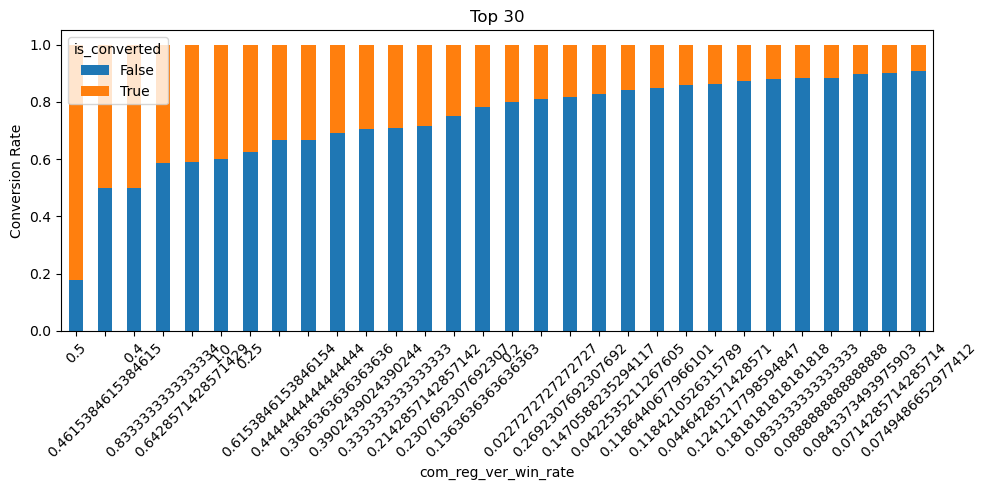

In [36]:
plot_top_conversion_rates(df_train, 'com_reg_ver_win_rate', 'is_converted', top_n=30)

# 4.customer_idx

In [37]:
df_train['customer_idx'].unique()

array([32160, 23122,  1755, ..., 19249, 40327, 30268])

In [38]:
print(df_train['customer_idx'].isnull().sum())
print(df_test['customer_idx'].isnull().sum())

0
0


In [39]:
df_train['customer_idx'].value_counts()

customer_idx
47466    7686
25096    2421
37680     367
18030     331
21321     162
         ... 
39487       1
41241       1
39422       1
22515       1
30268       1
Name: count, Length: 35112, dtype: int64

In [40]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['customer_idx'].unique())
test_vals = set(df_test['customer_idx'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

{16384, 1, 4, 8200, 9, 32776, 32779, 24588, 24589, 40973, 8208, 24592, 40976, 32787, 22, 40983, 8219, 30, 36, 8231, 24619, 43, 32813, 32814, 16431, 48, 24620, 8242, 41007, 54, 24632, 8249, 16452, 69, 24644, 8266, 8271, 41043, 16467, 24661, 32857, 16477, 24672, 32866, 24675, 32868, 104, 107, 41070, 16495, 41071, 113, 16497, 24691, 8305, 24687, 32888, 32892, 130, 41094, 136, 16521, 24714, 41098, 24717, 41103, 41108, 24727, 32924, 156, 163, 32931, 166, 167, 41137, 16562, 8372, 24758, 183, 41143, 32952, 8379, 41155, 32964, 16580, 32965, 32968, 32969, 24777, 16587, 204, 203, 205, 41166, 24778, 8401, 24780, 8406, 214, 24795, 41180, 8414, 16609, 16610, 8418, 32996, 8417, 33003, 24814, 16623, 16627, 41214, 24831, 256, 16641, 16645, 33033, 16651, 24844, 33037, 24846, 24848, 41235, 8474, 8475, 33050, 33052, 24862, 8479, 8480, 41247, 16681, 16683, 33072, 41265, 33078, 41273, 41274, 315, 24895, 16705, 8514, 33093, 24902, 24903, 24904, 41289, 8522, 24909, 33102, 8526, 33105, 33106, 33107, 33108, 24

In [41]:
# 너무많네...

In [42]:
# 딱히 관련 있는 칼럼도 없고..

In [43]:

top_values = df_train['customer_idx'].value_counts().tail(500)
print(top_values)


customer_idx
46688    1
43427    1
23508    1
3812     1
36774    1
        ..
39487    1
41241    1
39422    1
22515    1
30268    1
Name: count, Length: 500, dtype: int64


In [44]:
print((df_train['customer_idx'] == 0).any())


False


In [45]:
count_1 = (df_train['customer_idx'].value_counts() == 1).sum()
print(f"빈도수가 1인 행의 개수: {count_1}")


빈도수가 1인 행의 개수: 27331


In [46]:
# customer_idx 값별 빈도수 계산
idx_counts_train = df_train['customer_idx'].value_counts()
idx_counts_test = df_test['customer_idx'].value_counts()

# 빈도수가 1인 값들을 0으로 대체
df_train['customer_idx'] = df_train['customer_idx'].apply(lambda x: 0 if idx_counts_train[x] == 1 else x)
df_test['customer_idx'] = df_test['customer_idx'].apply(lambda x: 0 if idx_counts_test[x] == 1 else x)


In [47]:
top_values = df_train['customer_idx'].value_counts()
print(top_values)

customer_idx
0        27331
47466     7686
25096     2421
37680      367
18030      331
         ...  
29469        2
11339        2
20796        2
20026        2
33747        2
Name: count, Length: 7782, dtype: int64


In [48]:
# 'customer_idx' 열의 데이터 타입 확인
print(df_train['customer_idx'].dtype)

# 'customer_idx' 열을 범주형으로 변환 (만약 int64일 경우)!!!!?
df_train['customer_idx'] = df_train['customer_idx'].astype(str)
df_test['customer_idx'] = df_test['customer_idx'].astype(str)

# TargetEncoder 적용
target_encoder = TargetEncoder(smoothing=0.2)
df_train['customer_idx'] = target_encoder.fit_transform(df_train['customer_idx'], df_train['is_converted'])
df_test['customer_idx'] = target_encoder.transform(df_test['customer_idx'])  # 'transform'만 호출하여 새로운 데이터에 적용


int64


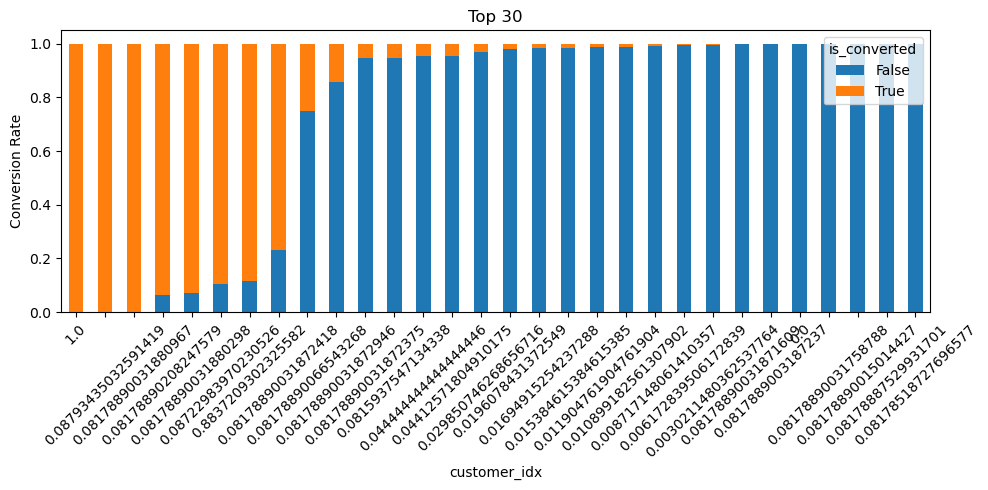

In [49]:
plot_top_conversion_rates(df_train, 'customer_idx', 'is_converted', top_n=30)

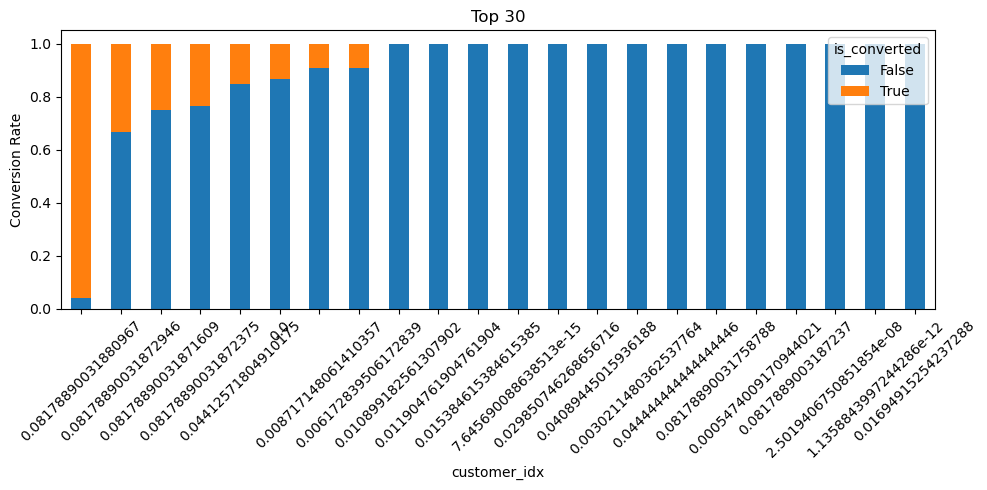

In [50]:
plot_top_conversion_rates(df_test, 'customer_idx', 'is_converted', top_n=30)

# 5.customer_type

In [51]:
df_train['customer_type'].value_counts()

customer_type
End-Customer                    6647
End Customer                    3996
Specifier/ Influencer           2525
Channel Partner                 1368
Service Partner                  349
Solution Eco-Partner             146
Installer/Contractor              52
Specifier / Influencer            43
Corporate                         31
HVAC Engineer                     23
Engineer                          20
Developer                         17
Technician                        16
Consultant                        15
Other                             10
Home Owner                        10
End-user                           8
Manager / Director                 8
Software/Solution Provider         7
Etc.                               6
Architect/Consultant               5
Homeowner                          5
Reseller                           5
Installer                          5
Interior Designer                  5
Distributor                        4
Others                  

In [52]:
# 소문자로 통일
df_train['customer_type'] = df_train['customer_type'].str.lower()

# 유사한 값 통합
df_train['customer_type'].replace({'end customer': 'end-customer',
                                   'specifier / influencer': 'specifier/influencer',
                                   'homeowner': 'home owner',
                                   'software / solution provider': 'software/solution provider',
                                   'manager / director': 'manager/director'}, inplace=True)




# 소문자로 통일
df_test['customer_type'] = df_test['customer_type'].str.lower()

# 유사한 값 통합
df_test['customer_type'].replace({'end customer': 'end-customer',
                                  'specifier / influencer': 'specifier/influencer',
                                  'homeowner': 'home owner',
                                  'software / solution provider': 'software/solution provider',
                                  'manager / director': 'manager/director'}, inplace=True)


In [53]:
df_train['customer_type'].value_counts()

customer_type
end-customer                  10643
specifier/ influencer          2525
channel partner                1368
service partner                 349
solution eco-partner            146
installer/contractor             52
specifier/influencer             43
corporate                        31
hvac engineer                    23
engineer                         20
developer                        17
technician                       16
consultant                       15
home owner                       15
other                            10
software/solution provider        8
manager/director                  8
end-user                          8
etc.                              6
installer                         5
interior designer                 5
reseller                          5
architect/consultant              5
distributor                       4
others                            4
system integrator                 2
dealer/distributor                2
technical assi

In [54]:
counts = df_train['customer_type'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['customer_type'] = df_train['customer_type'].replace(low_frequency, 'other')


In [56]:
counts = df_test['customer_type'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['customer_type'] = df_test['customer_type'].replace(low_frequency, 'other')

In [57]:
df_test['customer_type'].value_counts()

customer_type
end-customer             2454
specifier/ influencer     788
channel partner           327
solution eco-partner      146
service partner            98
other                       1
Name: count, dtype: int64

In [58]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['customer_type'].unique())
test_vals = set(df_test['customer_type'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

set()


In [59]:
# TargetEncoder 적용
target_encoder = TargetEncoder(smoothing=0.2)
df_train['customer_type'] = target_encoder.fit_transform(df_train['customer_type'], df_train['is_converted'])
df_test['customer_type'] = target_encoder.transform(df_test['customer_type'])  # 'transform'만 호출하여 새로운 데이터에 적용


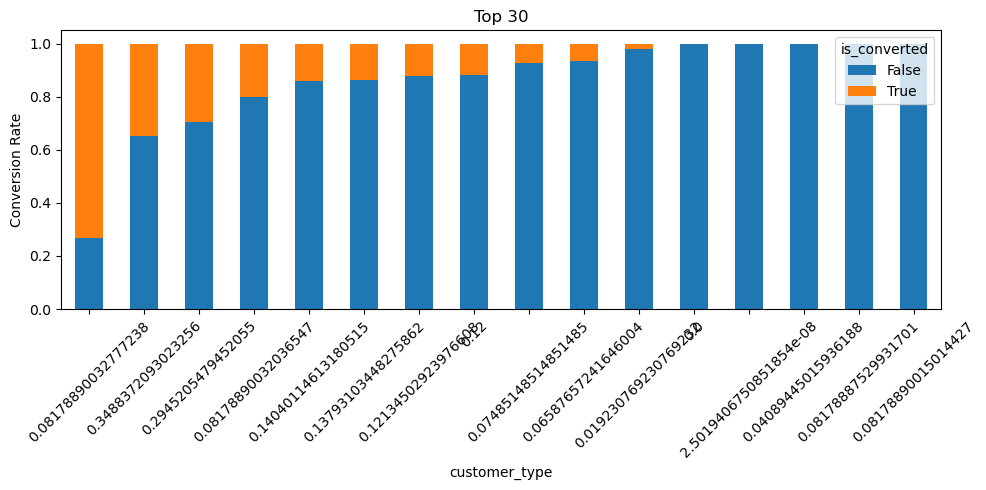

In [60]:
plot_top_conversion_rates(df_train, 'customer_type', 'is_converted', top_n=30)

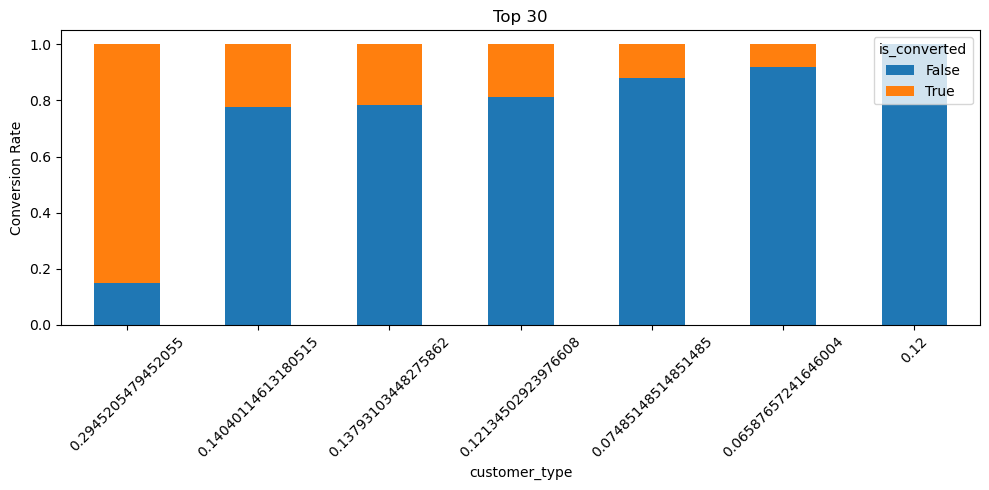

In [61]:
plot_top_conversion_rates(df_test, 'customer_type', 'is_converted', top_n=30)

# 6.historical_existing_cnt
- 이전에 Converted(영업 전환) 되었던 횟수

In [62]:
df_train['historical_existing_cnt'].value_counts()

historical_existing_cnt
4.0       2957
0.0       1973
1.0       1967
19.0      1441
16.0      1132
          ... 
404.0        1
145.0        1
1394.0       1
199.0        1
108.0        1
Name: count, Length: 136, dtype: int64

In [63]:
df_train['historical_existing_cnt'].isnull().sum()

45543

In [64]:
df_train['historical_existing_cnt'].describe()

count    13756.000000
mean        19.912184
std         44.697938
min          0.000000
25%          1.000000
50%          4.000000
75%         19.000000
max       1394.000000
Name: historical_existing_cnt, dtype: float64

In [65]:
#중앙값으로 결측치 채우기 (중간값이 평균보다 적절.. )
print(df_train['historical_existing_cnt'].mean(),df_train['historical_existing_cnt'].median())
print(df_test['historical_existing_cnt'].mean(),df_test['historical_existing_cnt'].median())

19.91218377435301 4.0
21.27294117647059 4.0


In [66]:
df_train['historical_existing_cnt'].fillna(df_train['historical_existing_cnt'].median(), inplace=True)
df_test['historical_existing_cnt'].fillna(df_test['historical_existing_cnt'].median(), inplace=True)

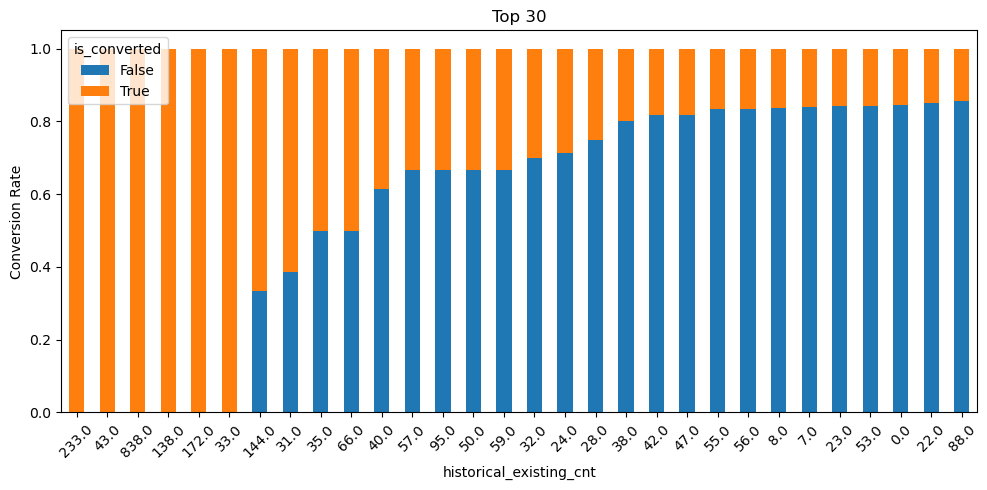

In [67]:
plot_top_conversion_rates(df_train, 'historical_existing_cnt', 'is_converted', top_n=30)

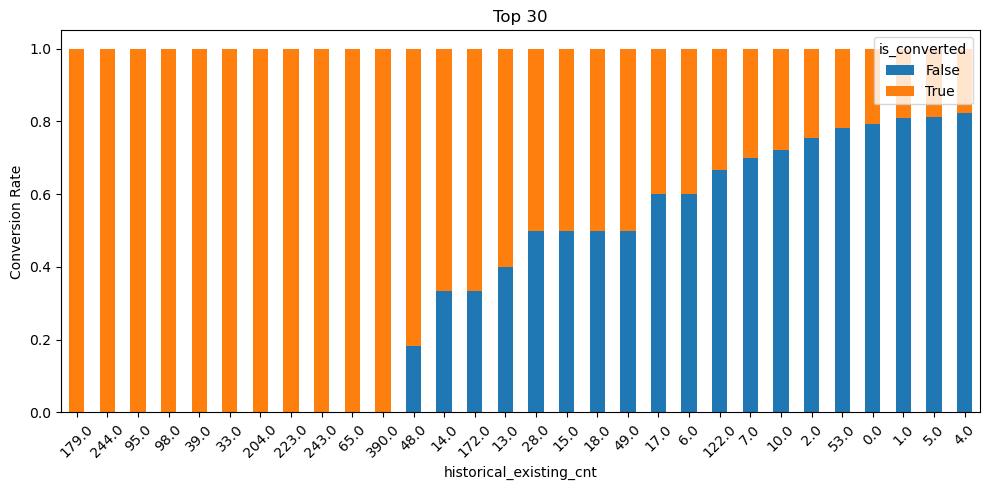

In [68]:
plot_top_conversion_rates(df_test, 'historical_existing_cnt', 'is_converted', top_n=30)

# 6. id_strategic_ver,it_strategic_ver,idit_strategic_ver
- id_strategic_ver : (도메인 지식) 특정 사업부(Business Unit이 ID일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여
- it_strategic_ver :	(도메인 지식) 특정 사업부(Business Unit이 IT일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여
- idit_strategic_ver : Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현

# 결측치가 특정 사업부를 의미한다면??? 
ex) [business_unit'] == 'ID']['business_area'] 값이 있는 확인 결측치 대체

In [69]:
df_train['id_strategic_ver'].isnull().sum()

55855

In [70]:

# 'business_unit'이 'ID'인 경우에 해당하는 'business_area' 값 출력
df_train[df_train['business_unit'] == 'ID']['business_area'].value_counts()




business_area
corporate / office                2460
retail                            2028
education                         1356
special purpose                   1075
hotel & accommodation              984
factory                            540
government department              421
residential (home)                 385
public facility                    271
transportation                     216
hospital & health care             148
power plant / renewable energy      43
Name: count, dtype: int64

In [71]:
df_train['id_strategic_ver'].value_counts()

id_strategic_ver
1.0    3444
Name: count, dtype: int64

In [72]:
# id_strategic_ver 열에서 NaN 값이 아닌 행들만 선택
id_s_data = df_train.dropna(subset=['id_strategic_ver'])

#business_unit과 business_area로 그룹을 지어 id_strategic_ver의 평균을 계산
id_s_data_x = id_s_data.groupby(['business_unit', 'business_area'])['id_strategic_ver'].mean()
id_s_data_x

business_unit  business_area        
ID             corporate / office       1.0
               hotel & accommodation    1.0
Name: id_strategic_ver, dtype: float64

### !!! 특정 사업부(Business Unit이 ID일 때) 는 즉 corporate / office  hotel & accommodation 일때를 의미한다.

In [73]:
def fill_strategic_ver(df):
    # 조건 설정
    condition = (
        (df['id_strategic_ver'].isna()) & 
        (df['business_unit'] == 'ID') & 
        ((df['business_area'] == 'corporate / office') | (df['business_area'] == 'hotel & accommodation'))
    )

    # 조건 해당하면 결측치를 1로 대체, 나머지는 0
    df.loc[condition, 'id_strategic_ver'] = df.loc[condition, 'id_strategic_ver'].fillna(1)
    df['id_strategic_ver'].fillna(0, inplace=True)


fill_strategic_ver(df_train)
fill_strategic_ver(df_test)


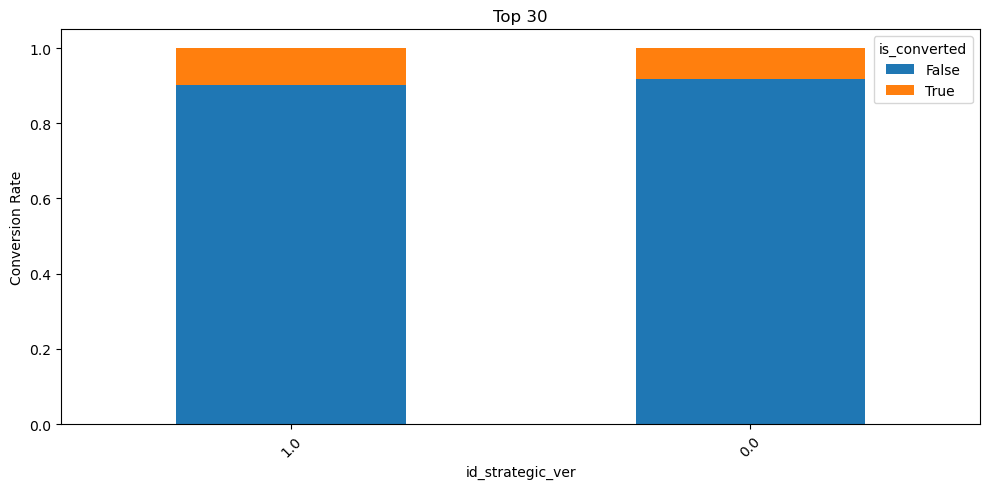

In [74]:
plot_top_conversion_rates(df_train, 'id_strategic_ver', 'is_converted', top_n=30)

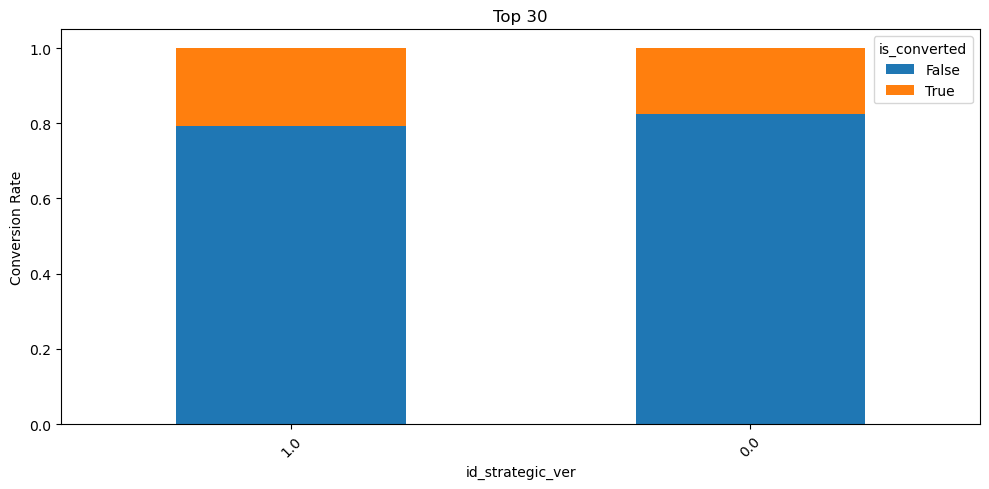

In [75]:
plot_top_conversion_rates(df_test, 'id_strategic_ver', 'is_converted', top_n=30)

# 7. it_strategic_ver

In [76]:
df_train['it_strategic_ver'].isnull().sum()

58178

In [77]:
# 'business_unit'이 'ID'인 경우에 해당하는 'business_area' 값 출력
df_train[df_train['business_unit'] == 'IT']['business_area'].value_counts()

business_area
hospital & health care            895
hotel & accommodation             791
corporate / office                330
retail                            163
education                         150
special purpose                   108
factory                            83
government department              49
residential (home)                 42
public facility                    40
transportation                     33
power plant / renewable energy      8
Name: count, dtype: int64

In [78]:
df_train['it_strategic_ver'].value_counts()

it_strategic_ver
1.0    1121
Name: count, dtype: int64

In [79]:
it_s_data = df_train.dropna(subset=['it_strategic_ver'])

it_s_data_x = it_s_data.groupby(['business_unit', 'business_area'])['it_strategic_ver'].mean()
it_s_data_x

business_unit  business_area        
IT             corporate / office       1.0
               hotel & accommodation    1.0
Name: it_strategic_ver, dtype: float64

In [80]:
def fill_strategic_ver(df):
    # 조건 설정
    condition = (
        (df['it_strategic_ver'].isna()) & 
        (df['business_unit'] == 'IT') & 
        ((df['business_area'] == 'corporate / office') | (df['business_area'] == 'hotel & accommodation'))
    )

    # 조건 해당하면 결측치를 1로 대체, 나머지는 0
    df.loc[condition, 'it_strategic_ver'] = df.loc[condition, 'it_strategic_ver'].fillna(1)
    df['it_strategic_ver'].fillna(0, inplace=True)

fill_strategic_ver(df_train)
fill_strategic_ver(df_test)


In [81]:
df_train['it_strategic_ver'].value_counts()

it_strategic_ver
0.0    58178
1.0     1121
Name: count, dtype: int64

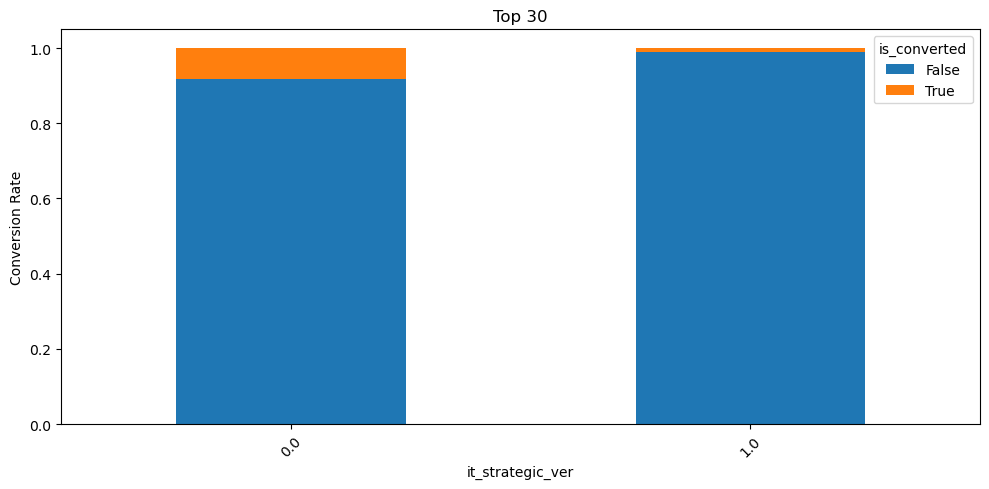

In [82]:
plot_top_conversion_rates(df_train, 'it_strategic_ver', 'is_converted', top_n=30)

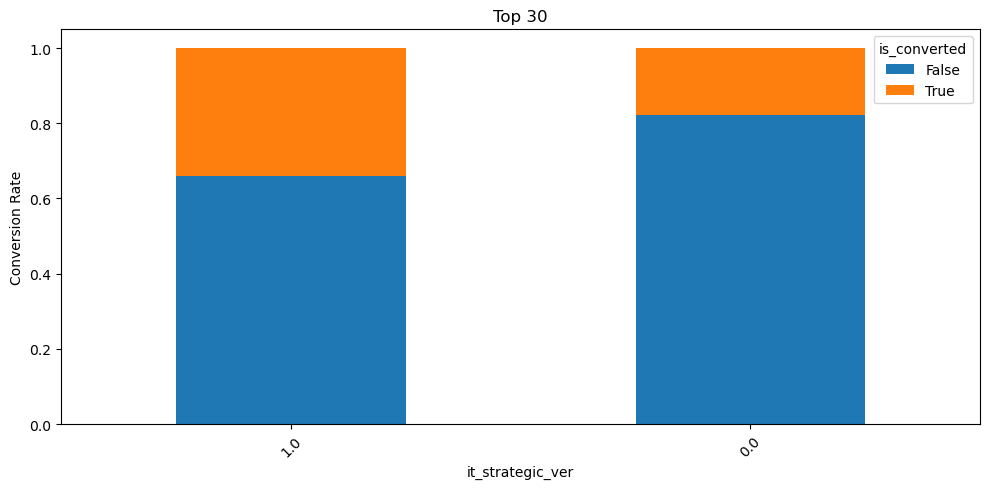

In [83]:
plot_top_conversion_rates(df_test, 'it_strategic_ver', 'is_converted', top_n=30)

# 8. idit_strategic_ver
- Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현

In [84]:
# id, it 둘중 하나라도 있으면 1 아니면 0으로 idit를 수정
df_train['idit_strategic_ver'] = np.where((df_train['id_strategic_ver'] == 1) | (df_train['it_strategic_ver'] == 1), 1, 0)

df_test['idit_strategic_ver'] = np.where((df_test['id_strategic_ver'] == 1) | (df_test['it_strategic_ver'] ==1), 1, 0)

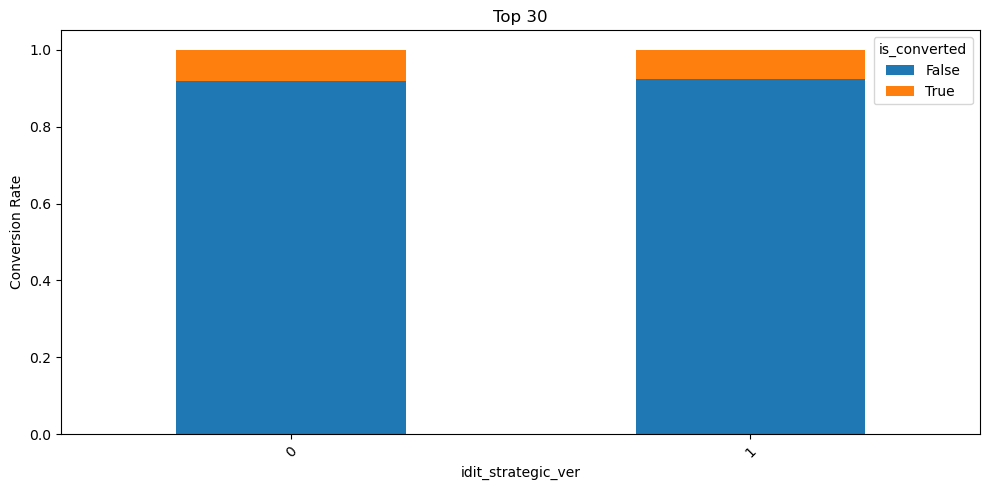

In [85]:
plot_top_conversion_rates(df_train, 'idit_strategic_ver', 'is_converted', top_n=30)

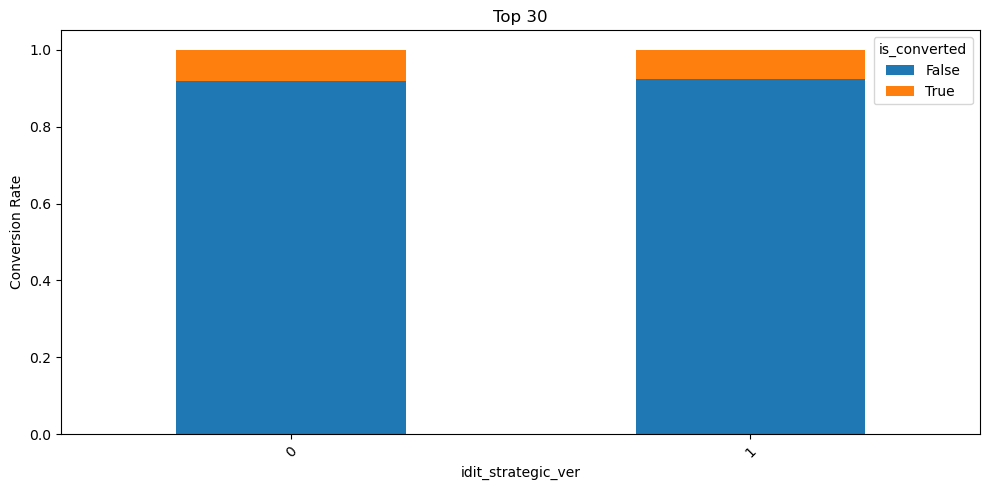

In [86]:
plot_top_conversion_rates(df_train, 'idit_strategic_ver', 'is_converted', top_n=30)

# product_category

In [87]:
categories = {
    'ultra stretch signage': 'DIGITAL Signage',
    'ultra stretch series': 'DIGITAL Signage',
    'signage': 'Signage',

    'led signage': 'LED Signage',
    'led aio 136': 'LED Signage',
    'meeting & screen sharedirect view leddirect view led': 'LED Signage',
    'laec015': 'LED Signage',
    'leadallin': 'LED Signage',
    'ledallinone': 'LED Signage',
    'laec015-gn.awz': 'LED Signage',
    'gscd046': 'LED Signage',
    'laec15': 'LED Signage',
    'lg led bloc': 'LED Signage',
    'lg magnit': 'LED Signage',
    'led cinema': 'LED Signage',
    'pantalla led outdoor': 'LED Signage',
    'gsca046': 'LED Signage',
    'gscd100': 'LED Signage',
    'lsca039': 'LED Signage',
    'essential series': 'LED Signage',

    'oled signage': 'OLED Signage',
    'transparent oled': 'OLED Signage',

    'uhd signage': 'DIGITAL Signage',
    'uh': 'DIGITAL Signage',

    'digital signage': 'DIGITAL Signage',
    'one:quick series': 'DIGITAL Signage',
    'lg one:quick': 'DIGITAL Signage',
    'lg one:quick series': 'DIGITAL Signage',
    'one quick works': 'DIGITAL Signage',
    'onequick series': 'DIGITAL Signage',
    'one quick:flex': 'DIGITAL Signage',
    'one:quick flex': 'DIGITAL Signage',
    'one:quick': 'DIGITAL Signage',
    '43uh5f-h.awzm': 'DIGITAL Signage',
    '49vl5g-m.awzm': 'DIGITAL Signage',
    'corpouh5f': 'DIGITAL Signage',
    'corpuh5f-': 'DIGITAL Signage',
    '86uh5f': 'DIGITAL Signage',
    '55tc3d': 'DIGITAL Signage',
    '5svh7f-a': 'DIGITAL Signage',
    'tr3': 'DIGITAL Signage',
    '98uh5e': 'DIGITAL Signage',
    'standard signage': 'DIGITAL Signage',
    'high brightness signage': 'DIGITAL Signage',
    'interactive signage': 'DIGITAL Signage',
    'special signage': 'DIGITAL Signage',
    'accessories': 'DIGITAL Signage',
    'standard': 'DIGITAL Signage',
    'high brightness': 'DIGITAL Signage',

    'tv signage': 'DIGITAL Signage',
    'smart tv signage': 'DIGITAL Signage',
    'ur640': 'DIGITAL Signage',
    'ur640s': 'DIGITAL Signage',

    'aio': 'AIO',
    'allinone_rmk': 'AIO',

    'system air conditioner': 'CAC',
    'single cac': 'CAC',
    'điều hòa trung tâm multi': 'CAC',
    'cac': 'CAC',
    'system ac': 'CAC',

    'vrf': 'VRF',
    'all lg vrf systems': 'VRF',
    'multi v5 vrf': 'VRF',
    'نظام التدفق المتغيرvrf': 'VRF',
    'vrf - multi v s': 'VRF',
    'kimatyzacja vrf': 'VRF',
    'điều hòa trung tâm vrf': 'VRF',
    'systèmes de débit à réfrigérant variable (drv)': 'VRF',

    'điều hòa trung tâm chiller': 'Chiller',
    'chiller': 'Chiller',
    'مبرد (تشيلر)': 'Chiller',
    'chiller/enfriadoras': 'Chiller',

    'software solution': 'Solution',
    'signage care solution': 'Solution',
    'signage care solutions': 'Solution',
    'lg home bliss air solution': 'Solution',
    'lg paradise air solution': 'Solution',
    'lg salang air solution for dream homes': 'Solution',
    'حلول التدفئة': 'Solution',
    'pro:centric': 'Solution',
    'pro centric hotel': 'Solution',
    'procentric': 'Solution',

    'heating': 'Heating',
    'חימום': 'Heating',
    'isıtma': 'Heating',
    'ogrzewanie (pompy ciepła)': 'Heating',
    'calefacción': 'Heating',
    'aquecimento': 'Heating',

    'rac': 'RAC',
    'điều hòa gia dụng': 'RAC',
    'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'RAC',
    'ac rumah': 'RAC',
    'aire acondicionado residencial': 'RAC',
    'climatiseur résidentiel': 'RAC',
    'điều hòa cục bộ': 'RAC',
    'residential air conditioner': 'RAC',
    'מזגנים למקום מגורים': 'RAC',
    'تكييفات': 'RAC',
    'ar condicionado residencial': 'RAC',
     'pendingin': 'RAC',

    'commercial display': 'Display',
    'medical display': 'Display',
    '互動式顯示屏': 'Display',
    'led 顯示屏': 'Display',
    '標準顯示屏': 'Display',
    'collaboration displays': 'Display',
    'oled 顯示屏': 'Display',
    'window facing display': 'Display',
    'medical displays': 'Display',
    'radiology displays': 'Display',
    'taa lcd lfd displays': 'Display',
    '特別顯示屏': 'Display',
    '高亮度顯示屏': 'Display',

    'hotel tv': 'TV',
    'commercial tv': 'TV',
    'hospital tv': 'TV',
    'tv': 'TV',
    '酒店電視': 'TV',
    'tv,commercial tv': 'TV',
    'htv': 'TV',
    'tv 60"': 'TV',
    'comercial tv': 'TV',
    '醫院電視': 'TV',
    'ctv': 'TV',
    'smart tv': 'TV',
    'tv 55"': 'TV',
    'tv 43 pol': 'TV',
    '43us660h0sd.awz': 'TV',
    '50uq801c0sb.bwz': 'TV',
    '55us660h0sd.bwz': 'TV',
    '32lq621cbsb.awz': 'TV',
    '55uq801c0sb.bwz': 'TV',
    '43uq751c0sf.bwz': 'TV',
    '43uq751c0sb.bwz': 'TV',
    '50us660h0sd.bwz': 'TV',
    '43us660h (na)': 'TV',
    'hoteleria_us670h': 'TV',

    'monitor': 'Monitor',
    'computer monitors': 'Monitor',
    'medical monitors': 'Monitor',
    'monitor & pc': 'Monitor',
    'medical monitor': 'Monitor',
    'surgical monitor': 'Monitor',
    '28mq780': 'Monitor',
    'medical- surgical': 'Monitor',
    'monitorindustrial_rmk': 'Monitor',

    'multi-split': 'Multi Split',
    'multi split': 'Multi Split',
    'פיצול מרובה': 'Multi Split',
    'multi-split (plusieurs pièces)': 'Multi Split',
    'klimatyzacja multi-split': 'Multi Split',

    'single-split': 'Single Split',
    'single split': 'Single Split',
    'split tunggal': 'Single Split',

    'videowall_rmk': 'Video Wall',
    'videwall': 'Video Wall',
    '110 + video wall': 'Video Wall',
    'video wall': 'Video Wall',
    '49vl5g-m': 'Video Wall',
    '55vm5e-a': 'Video Wall',
    '55vm5j-h': 'Video Wall',
    '49vl5f': 'Video Wall',
    'videowall signage': 'Video Wall',

    'etc.': 'Other',
    'lainnya': 'Other',
    'אחר': 'Other',
    'ฯลฯ': 'Other',
    'khác': 'Other',
    'outros': 'Other',
    'آخر': 'Other',
    'not specified': 'Other',
    'other': 'Other',
    'others': 'Other',
    'otros': 'Other',
    'autre': 'Other',

    'idb': 'IDB',
    'interactive digital board': 'IDB',

     'washing machine,dryer': 'Several',
     'solar,chiller': 'Several',
     'system ac,rac': 'Several',
     'monitor signage,commercial tv,monior/monitor tv': 'Several',
     'monitor signage,monior/monitor tv': 'Several',
     'aircare,built-in/cooking': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,projector,tv': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,tv': 'Several',
     'commercial tv,tv': 'Several',
     'monitor signage,commercial tv,solar,ess,monior/monitor tv,pc,projector,robot,system ac,ems,rac,chill': 'Several',
     'monior/monitor tv,tv': 'Several',
     'chiller,aircare': 'Several',
     'solar,aircare': 'Several',
     'commercial tv,audio/video': 'Several',
     'solar,ess': 'Several',
     'solar,system ac': 'Several',
     'vrf,multi-split': 'Several',
     'vrf,multi-split,chiller': 'Several',
     'vrf,multi-split,single-split,chiller,heating': 'Several',
     'system ac,solar,washing machine': 'Several',
     'solar,ess,ems': 'Several',
     'tv,mobile': 'Several',
     'commercial tv,projector': 'Several',
     'aircare,water care': 'Several',
     'monior/monitor tv,chiller': 'Several',
     'system ac,chiller': 'Several',
     'system ac,aircare': 'Several',
     'monitor signage,commercial tv': 'Several',
     'system ac,tv': 'Several',
     'monitor signage,audio/video': 'Several',
     'monitor signage,commercial tv,solar,ess,monior/monitor tv,pc': 'Several',
     'monitor signage,pc': 'Several',
     'monitor signage,commercial tv,solar,ess': 'Several',
     'monior/monitor tv,system ac,tv,refrigerator,washing machine,dryer,built-in/cooking': 'Several',
     'commercial tv,robot': 'Several',
     'monitor signage,solar': 'Several',
     'solar,projector': 'Several',
     'tv,audio/video': 'Several',
     'solar,dryer': 'Several',
     'solar,monior/monitor tv': 'Several',
     'chiller,dryer': 'Several',
     'monior/monitor tv,pc': 'Several',
     'solar,refrigerator': 'Several',
     'monitor signage,system ac': 'Several',
     'system air conditioner,solar': 'Several',
     'solar,tv': 'Several',
     'monitor signage,tv': 'Several',
     'dryer,chiller': 'Several',
     'monitor signage,monior/monitor tv,system ac,vacuum cleaner,tv,home beauty,commercial tv,mobile,audio': 'Several',
     'solar,vacuum cleaner': 'Several',
     'solar,monior/monitor tv,pc,tv,refrigerator,washing machine,dryer,home beauty': 'Several',
     'monitor signage,solar,robot,water care': 'Several',
     'mobile,audio/video': 'Several',
     'system ac,refrigerator,washing machine,dryer': 'Several',
     'solar,system ac,aircare': 'Several',
     'projector,system ac,water care': 'Several',
     'chiller,water care': 'Several',
     'monior/monitor tv,tv,commercial tv,pc,refrigerator,solar,rac,washing machine,mobile,ess,audio/video': 'Several',
     'ess,chiller': 'Several',
     'monitor signage,monior/monitor tv,pc,tv': 'Several',
     'solar,water care': 'Several',
     'digital signage or commercial tvs': 'Several',
     'monitor signage,commercial tv,audio/video': 'Several',
     'solar,built-in/cooking': 'Several',
     'monitor signage,monior/monitor tv,commercial tv': 'Several',
     'commercial tv,monior/monitor tv': 'Several',
     'robot,system ac': 'Several',
     'commercial tv,water care': 'Several',
     'pc,washing machine': 'Several',
     'monitor signage,solar,monior/monitor tv,pc,projector,robot,system ac,tv,refrigerator,washing machine': 'Several',
     'system ac,tv,refrigerator,washing machine,built-in/cooking,audio/video': 'Several',
     'system air conditioner,energy storage system': 'Several',
     'system ac,home beauty': 'Several',
     'information display,monitor': 'Several',
     'rac/cac': 'Several',
     'system ac,chiller,aircare': 'Several',
     'tv,refrigerator,washing machine': 'Several',
     'monior/monitor tv,refrigerator': 'Several',
     'monior/monitor tv,system ac,tv,pc,refrigerator,water care,solar,washing machine,mobile,chiller,built': 'Several',
     'projector,audio/video': 'Several',
     'monior/monitor tv,audio/video': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,pc,tv,home beauty,audio/video': 'Several',
     'pc,robot,system ac,chiller,tv,refrigerator,washing machine,vacuum cleaner,styler,dryer,mobile,audio/': 'Several',
     'refrigerator,washing machine,built-in/cooking': 'Several',
     'monitor signage,monior/monitor tv,tv,audio/video': 'Several',
     'tv,refrigerator,washing machine,vacuum cleaner,audio/video': 'Several',
     'pc,tv': 'Several',
     'aircare,mobile': 'Several',
     'solar,ess,system ac': 'Several',
     'system ac,refrigerator': 'Several',
     'tv,pc': 'Several',
     'monitor signage,commercial tv,solar,pc,projector,system ac,ems,rac,chiller,refrigerator,washing mach': 'Several',
     'chiller,refrigerator': 'Several',
     'monitor signage,commercial tv,solar,projector,robot,chiller,refrigerator,built-in/cooking,water care': 'Several',
     'commercial tv,solar': 'Several',
     'monior/monitor tv,projector,audio/video': 'Several',
     'refrigerator,chiller': 'Several',
     'chiller,tv': 'Several',
     'projector,ems': 'Several',
     'vrf,chiller': 'Several',
     'monitor signage,mobile': 'Several',
     'robot,vacuum cleaner': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,audio/video': 'Several',
     'video wall + aio': 'Several',
     'vrf,single-split': 'Several',
     'vrf,multi-split,single-split,chiller,etc.': 'Several',
     'multi-split,single-split': 'Several',
     'vrf,multi-split,single-split': 'Several',
     'vrf,multi-split,etc.': 'Several',
     'vrf,multi-split,heating': 'Several',
     'vrf,multi-split,single-split,chiller': 'Several',
     'vrf,multi-split,single-split,heating': 'Several',
     'vrf,single-split,chiller': 'Several',
     'commercial tv,solar,ess,projector,system ac,tv,washing machine,home beauty,audio/video': 'Several',
     'solar,robot': 'Several',
     'monitor signage,commercial tv,monior/monitor tv,pc,projector,tv,audio/video': 'Several',
     'solar,energy storage system': 'Several',
     'system ac,solar': 'Several',
     'solar,system ac,water care': 'Several',
     'vrf,heating': 'Several',
     'monitor signage,monior/monitor tv,vacuum cleaner,tv,home beauty,commercial tv,pc,refrigerator,styler': 'Several',
     'refrigerator,built-in/cooking': 'Several',
     'ems,audio/video': 'Several',
     'projector,ems,mobile,audio/video': 'Several',
     'commercial tv,solar,ess,monior/monitor tv,pc,projector,robot,system ac,ems,rac,chiller,refrigerator,': 'Several',
     'tv,refrigerator': 'Several',
     'monior/monitor tv,refrigerator,audio/video': 'Several'
}

# 주어진 값을 카테고리에 따라 변환
def map_to_category(value):
    return categories.get(value, value)

# 판다스 시리즈를 입력으로 받아 카테고리에 따라 변환된 값을 반환
def transform_column_values_series(column_series):
    return column_series.map(map_to_category)


# 변환된 칼럼 값 출력
df_train['product_category'] = transform_column_values_series(df_train['product_category'])
df_test['product_category'] = transform_column_values_series(df_test['product_category'])

In [88]:
count_1 = (df_train['product_category'].value_counts() == 1).sum()
print(f"빈도수가 1인 행의 개수: {count_1}")

빈도수가 1인 행의 개수: 19


In [89]:
df_train['product_category']= df_train['product_category'].fillna('None')
df_test['product_category']= df_test['product_category'].fillna('None')

In [90]:
df_train['product_category'].value_counts()

product_category
None                        19374
IDB                          6185
VRF                          5736
DIGITAL Signage              5615
Multi Split                  3683
                            ...  
32 / 43 pol                     1
high inch 86 / 98 or 110        1
refrigerator                    1
aio | one quick                 1
parts                           1
Name: count, Length: 75, dtype: int64

In [91]:
counts = df_train['product_category'].value_counts()
threshold = 11
low_frequency = counts[counts < threshold].index
df_train['product_category'] = df_train['product_category'].replace(low_frequency, 'Other')

In [92]:
df_train['product_category'].value_counts()

product_category
None                            19374
IDB                              6185
VRF                              5736
DIGITAL Signage                  5615
Multi Split                      3683
Other                            2257
video wall signage               2029
LED Signage                      1939
RAC                              1770
Single Split                     1576
TV                               1371
OLED Signage                     1352
Display                          1121
Chiller                          1057
Monitor                           807
Heating                           713
ventilation                       420
Solution                          366
Several                           323
teto ou cassete inverter          308
control                           263
multi inverter                    257
webos                             144
Video Wall                        122
pc                                114
projector                        

In [93]:
df_test['product_category'].value_counts()

product_category
None                  1858
VRF                    726
DIGITAL Signage        595
Multi Split            544
LED Signage            289
Other                  207
Single Split           179
video wall signage     167
TV                     144
OLED Signage           104
Chiller                 99
IDB                     74
Heating                 67
Monitor                 58
Display                 32
ventilation             31
Solution                22
cloud device            18
webos                   14
laptop                  13
control                 13
projector               12
ess                      4
notebook                 1
Name: count, dtype: int64

In [94]:
counts = df_test['product_category'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_test['product_category'] = df_test['product_category'].replace(low_frequency, 'Other')

In [95]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['product_category'].unique())
test_vals = set(df_test['product_category'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

set()


In [96]:
# TargetEncoder 적용
target_encoder = TargetEncoder(smoothing=0.5)
df_train['product_category'] = target_encoder.fit_transform(df_train['product_category'], df_train['is_converted'])
df_test['product_category'] = target_encoder.transform(df_test['product_category'])  # 'transform'만 호출하여 새로운 데이터에 적용


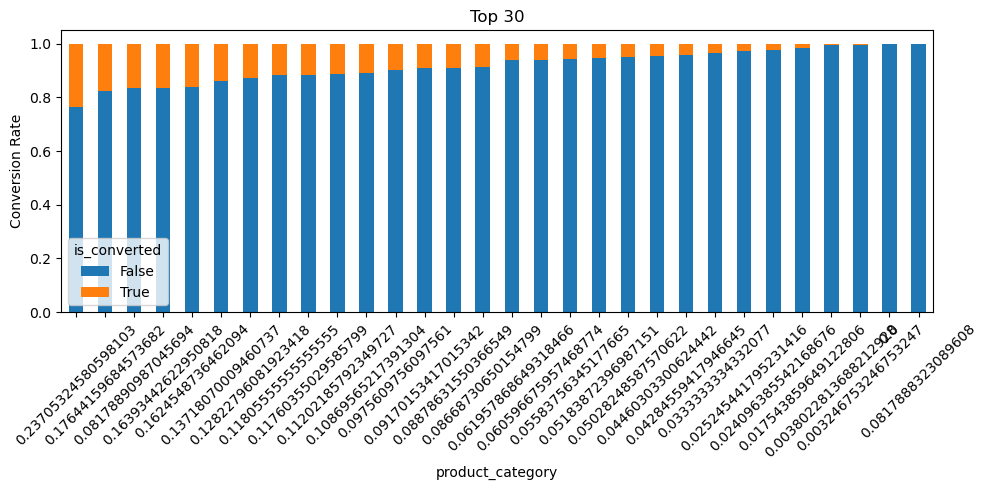

In [97]:
plot_top_conversion_rates(df_train, 'product_category', 'is_converted', top_n=30)

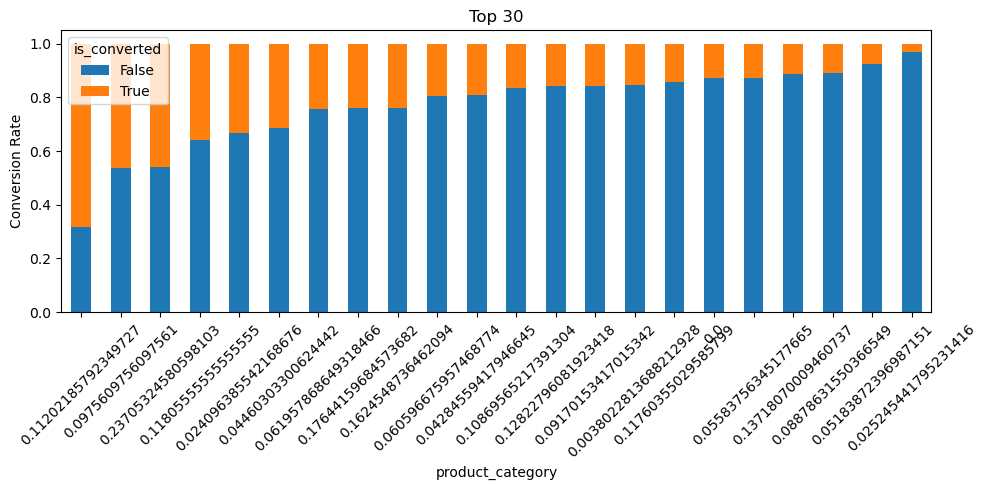

In [98]:
plot_top_conversion_rates(df_test, 'product_category', 'is_converted', top_n=30)

# expected_timeline

In [99]:
import pandas as pd

def update_expected_timeline(value):
    if pd.notna(value):
        original_value = value
        mapping_rules = {
            ('requi', 'reqi'): 'requirement',
            ('no', 'not'): 'no requirement',
            ('follow',): 'follow',
            ('details',): 'details shared',
            ('call back', 'call later', 'call after'): 'call back'
        }
        for keywords, updated_value in mapping_rules.items():
            if any(keyword in value for keyword in keywords):
                return updated_value
        return original_value


def mapping(df, timeline_mapping):
    df['expected_timeline'] = df['expected_timeline'].apply(update_expected_timeline)
    df['expected_timeline'] = df['expected_timeline'].map(timeline_mapping).fillna(df['expected_timeline'])
    return df

timeline_mapping = {
    "less than 3 months": "0-3m",
    "less_than_3_months": "0-3m",
    
    "3 months ~ 6 months": "3-6m",
    "3_months_~6_months": "3-6m",
    "3_months_~_6_months": "3-6m",
    
    "6 months ~ 9 months": "6-9m",
    "6_months~9_months": "6-9m",
    
    "9 months ~ 1 year": "9-12m",
    "9_months~_1_year": "9-12m",
    "9_months_~_1_year": "9-12m",
    
    "up to december": "1y",
    "more than a year": "1y",
    "more_than_a_year": "1y",
    
    "couldn't connect": "no response",
    "didn't respond": "no response",
    "rnr": "no response",
    "reponse": "response"
}


df_train = mapping(df_train, timeline_mapping)
df_test = mapping(df_test, timeline_mapping)

# nan을 'no requirement'로 채우기
df_train['expected_timeline'].fillna('no requirement', inplace=True)
df_test['expected_timeline'].fillna('no requirement', inplace=True)


In [100]:
df_train['expected_timeline'].value_counts()

expected_timeline
no requirement                                                                                                                  30983
0-3m                                                                                                                            17326
3-6m                                                                                                                             5035
1y                                                                                                                               3028
9-12m                                                                                                                            1107
                                                                                                                                ...  
received po.                                                                                                                        1
september                                   

In [101]:
counts = df_train['expected_timeline'].value_counts()
threshold = 10
low_frequency = counts[counts < threshold].index
df_train['expected_timeline'] = df_train['expected_timeline'].replace(low_frequency, 'Other')

In [102]:
df_train['expected_timeline'].value_counts()

expected_timeline
no requirement        30983
0-3m                  17326
3-6m                   5035
1y                     3028
9-12m                  1107
6-9m                   1098
Other                   220
requirement             112
follow                  108
less than 6 months      108
etc.                     95
details shared           45
no response              17
call back                17
Name: count, dtype: int64

In [103]:
df_test['expected_timeline'].value_counts()

expected_timeline
no requirement    2408
0-3m              1734
3-6m               426
1y                 272
9-12m              264
6-9m               167
Name: count, dtype: int64

In [104]:
# TargetEncoder 적용
target_encoder = TargetEncoder(smoothing=0.2)
df_train['expected_timeline'] = target_encoder.fit_transform(df_train['expected_timeline'], df_train['is_converted'])
df_test['expected_timeline'] = target_encoder.transform(df_test['expected_timeline'])  # 'transform'만 호출하여 새로운 데이터에 적용


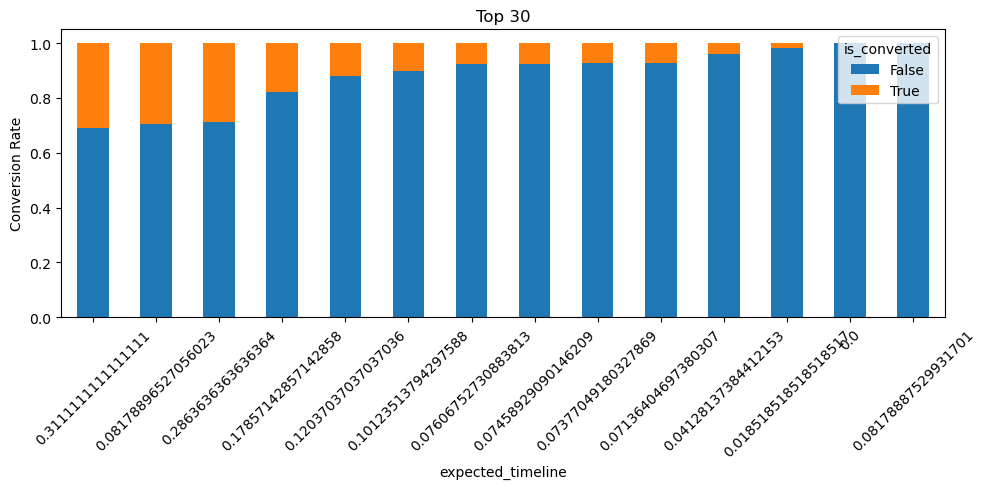

In [105]:
plot_top_conversion_rates(df_train, 'expected_timeline', 'is_converted', top_n=30)

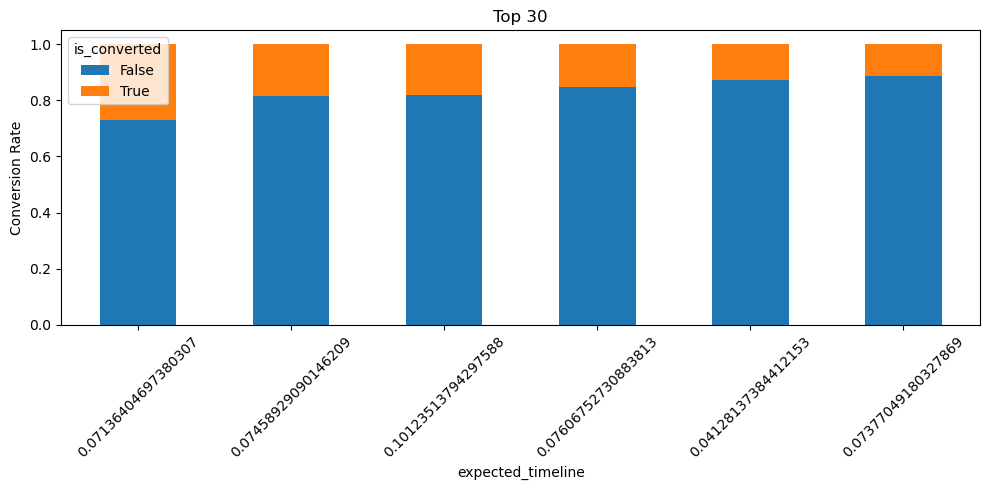

In [106]:
plot_top_conversion_rates(df_test, 'expected_timeline', 'is_converted', top_n=30)

# business_subarea

In [107]:
# df_train
grouped_data_train = df_train.groupby('business_area')['business_subarea'].apply(list)
mode_subarea_by_area_train = df_train.groupby('business_area')['business_subarea'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_train['business_subarea'] = df_train.apply(lambda row: mode_subarea_by_area_train.get(row['business_area'], row['business_subarea']), axis=1)

# df_test
grouped_data_test = df_test.groupby('business_area')['business_subarea'].apply(list)
mode_subarea_by_area_test = df_test.groupby('business_area')['business_subarea'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_test['business_subarea'] = df_test.apply(lambda row: mode_subarea_by_area_test.get(row['business_area'], row['business_subarea']), axis=1)

### 레이블 인코딩

In [108]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [110]:
# 레이블 인코딩할 칼럼들
label_columns = [
    #"customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    #"customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    #"product_category",
    "product_subcategory",
    "product_modelname",
    #"customer_country.1",
    "customer_position",
    "response_corporate",
    #"expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

In [111]:
df_all

,business_subarea,business_area,business_unit,enterprise,customer_job,inquiry_type,product_subcategory,product_modelname,customer_position,response_corporate
0,7,0,0,0,420,32,349,699,47,33
1,7,0,0,0,303,32,349,699,21,33
2,7,0,0,0,160,27,349,699,80,21
3,7,0,0,0,166,32,349,699,21,21
4,7,0,0,0,84,32,349,699,80,21
...,...,...,...,...,...,...,...,...,...,...
5266,11,6,0,0,468,30,349,699,9,43
5267,11,6,3,0,323,30,349,699,74,50
5268,11,6,0,0,166,58,349,699,64,43
5269,11,6,3,1,323,58,349,699,74,12


다시 학습 데이터와 제출 데이터를 분리합니다.

In [112]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [113]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=684050,
)





## 3. 모델 학습

### 모델 정의 

In [114]:
model = DecisionTreeClassifier()

### 모델 학습

In [115]:
model.fit(x_train.fillna(0), y_train)

DecisionTreeClassifier()

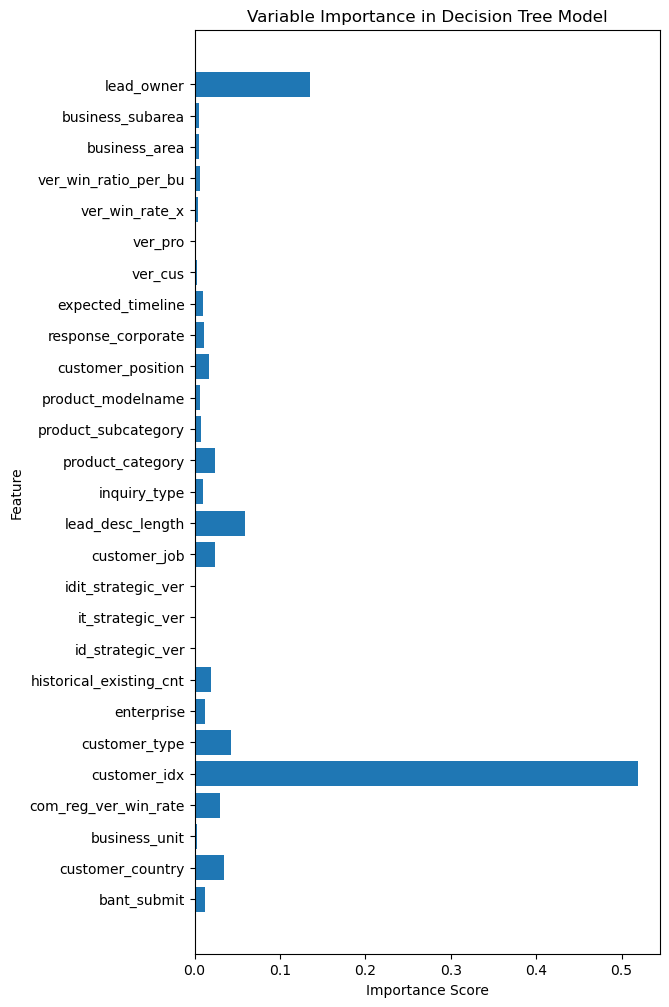

In [116]:
# 변수 중요도 확인
feature_importances = model.feature_importances_

plt.figure(figsize=(6, 12))
plt.barh(range(x_train.shape[1]), feature_importances, align='center')
plt.yticks(range(x_train.shape[1]), x_train.columns)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Variable Importance in Decision Tree Model')
plt.show()

### 모델 성능 보기

In [117]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [118]:
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)

오차행렬:
 [[  810   177]
 [  217 10656]]

정확도: 0.9668
정밀도: 0.7887
재현율: 0.8207
F1: 0.8044


## 4. 제출하기

### 테스트 데이터 예측

In [119]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [120]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

949

### 제출 파일 작성

In [121]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**